In [2]:
import torch
from PIL import Image
import sys
from pathlib import Path

root_dir = Path().resolve().parent
sys.path.append(str(root_dir))

from metric_depth.zoedepth.models.builder import build_model
from metric_depth.zoedepth.utils.config import get_config
from metric_depth.zoedepth.utils.misc import save_raw_16bit, colorize

# Load the model
config = get_config("zoedepth", "eval", "kitti")
config.pretrained_resource = "local::/checkpoints/depth_anything_metric_depth_outdoor.pt"
zoe = build_model(config).to('cuda' if torch.cuda.is_available() else 'cpu')

xFormers not available
xFormers not available


Params passed to Resize transform:
	width:  518
	height:  392
	resize_target:  True
	keep_aspect_ratio:  False
	ensure_multiple_of:  14
	resize_method:  minimal
Using pretrained resource local::/checkpoints/depth_anything_metric_depth_outdoor.pt
Loaded successfully


In [3]:
image = Image.open("/home/emilia/MasterOfFish/sintef_data/YC1/frames/left/frame_0.jpg")

# show the image
# image.show()

depth = zoe.infer_pil(image)


colorized = colorize(depth, cmap="plasma")
output_path = "/home/emilia/MasterOfFish/sintef_data/YC1/depthAny/indoor_nyu.png"
Image.fromarray(colorized).save(output_path)

In [4]:
import sys
from pathlib import Path

root_dir = Path().resolve().parent.parent  
sys.path.append(str(root_dir))


from Baseline.lib.calibration import StereoManager, CameraParameters, StereoParameters
calib_path = "/home/emilia/MasterOfFish/StereoDepth/stereoMap.pickle"

sm = StereoManager()
sm.load_calibration(calib_path)

left_fx = sm.cam_parameters[0].camera_matrix[0, 0]
left_fy = sm.cam_parameters[0].camera_matrix[1,1]

right_fx = sm.cam_parameters[1].camera_matrix[0, 0]
right_fy = sm.cam_parameters[1].camera_matrix[1,1]




In [4]:
import argparse
import os
import glob
import torch
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
# import open3d as o3d
from tqdm import tqdm
from zoedepth.models.builder import build_model
from zoedepth.utils.config import get_config
import pandas as pd

# Global settings
FL = 715.0873
FY = left_fy
FX = left_fx
NYU_DATA = False
FINAL_HEIGHT = 256
FINAL_WIDTH = 256
INPUT_DIR = './my_test/input'
OUTPUT_DIR = './my_test/output'
DATASET = 'kitti' 

def process_images(model):
    if not os.path.exists(OUTPUT_DIR):
        os.makedirs(OUTPUT_DIR)

    image_paths = glob.glob(os.path.join(INPUT_DIR, '*.png')) + glob.glob(os.path.join(INPUT_DIR, '*.jpg'))
    for image_path in tqdm(image_paths, desc="Processing Images"):
        try:
            color_image = Image.open(image_path).convert('RGB')
            original_width, original_height = color_image.size
            image_tensor = transforms.ToTensor()(color_image).unsqueeze(0).to('cuda' if torch.cuda.is_available() else 'cpu')

            pred = model(image_tensor, dataset=DATASET)
            if isinstance(pred, dict):
                pred = pred.get('metric_depth', pred.get('out'))
            elif isinstance(pred, (list, tuple)):
                pred = pred[-1]
            pred = pred.squeeze().detach().cpu().numpy()

            # Resize color image and depth to final size
            resized_color_image = color_image.resize((FINAL_WIDTH, FINAL_HEIGHT), Image.LANCZOS)
            resized_pred = Image.fromarray(pred).resize((FINAL_WIDTH, FINAL_HEIGHT), Image.NEAREST)

            focal_length_x, focal_length_y = (FX, FY) #if not NYU_DATA else (FL, FL)
            x, y = np.meshgrid(np.arange(FINAL_WIDTH), np.arange(FINAL_HEIGHT))
            x = (x - FINAL_WIDTH / 2) / focal_length_x
            y = (y - FINAL_HEIGHT / 2) / focal_length_y
            z = np.array(resized_pred)
            points = np.stack((np.multiply(x, z), np.multiply(y, z), z), axis=-1).reshape(-1, 3)
            colors = np.array(resized_color_image).reshape(-1, 3) / 255.0

            # pcd = o3d.geometry.PointCloud()
            # pcd.points = o3d.utility.Vector3dVector(points)
            # pcd.colors = o3d.utility.Vector3dVector(colors)
            # o3d.io.write_point_cloud(os.path.join(OUTPUT_DIR, os.path.splitext(os.path.basename(image_path))[0] + ".ply"), pcd)

            df = pd.DataFrame(points, columns=['x', 'y', 'z'])
            df[['red', 'green', 'blue']] = pd.DataFrame(colors * 255, index=df.index)  # Assuming colors were normalized to [0, 1]
            df_output_path = os.path.join(OUTPUT_DIR, os.path.splitext(os.path.basename(image_path))[0] + ".csv")
            df.to_csv(df_output_path, index=False)

        except Exception as e:
            print(f"Error processing {image_path}: {e}")

def main(model_name, pretrained_resource):
    config = get_config(model_name, "eval", DATASET)
    config.pretrained_resource = pretrained_resource
    model = build_model(config).to('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    process_images(model)




In [5]:

main("zoedepth", "local::/checkpoints/depth_anything_metric_depth_outdoor.pt")

Params passed to Resize transform:
	width:  518
	height:  392
	resize_target:  True
	keep_aspect_ratio:  False
	ensure_multiple_of:  14
	resize_method:  minimal
Using pretrained resource local::/checkpoints/depth_anything_metric_depth_outdoor.pt
Loaded successfully


Processing Images: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


In [6]:
import pandas as pd

df = pd.read_csv('/home/emilia/MasterOfFish/DepthAny/metric_depth/my_test/output/frame_0.csv')

print(df.head())

          x         y         z    red  green   blue
0 -0.396182 -0.397174  5.041075  115.0  113.0  126.0
1 -0.415875 -0.420199  5.333317  113.0  111.0  124.0
2 -0.425423 -0.433258  5.499063  112.0  110.0  123.0
3 -0.433990 -0.445518  5.654672  109.0  108.0  121.0
4 -0.438566 -0.453846  5.760377  114.0  110.0  121.0


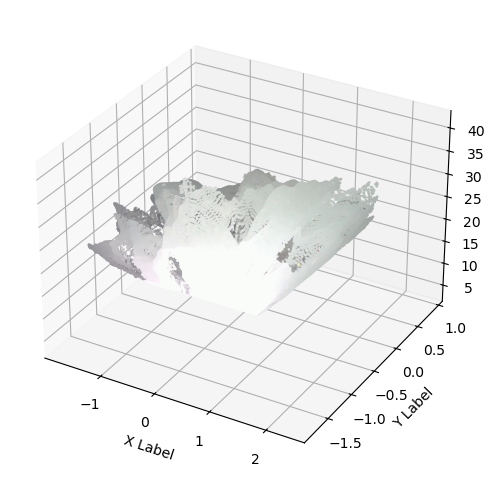

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Creating a 3D plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plotting
scatter = ax.scatter(df['x'], df['y'], df['z'], c=df[['red', 'green', 'blue']] / 255, s=1)  # Assuming color values are in [0, 255]

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

# https://github.com/isl-org/ZoeDepth/blob/main/ui/gradio_im_to_3d.py

In [1]:
import numpy as np
import trimesh
from zoedepth.utils.geometry import depth_to_points, create_triangles
from functools import partial
import tempfile
from PIL import Image


def depth_edges_mask(depth):
    """Returns a mask of edges in the depth map.
    Args:
    depth: 2D numpy array of shape (H, W) with dtype float32.
    Returns:
    mask: 2D numpy array of shape (H, W) with dtype bool.
    """
    # Compute the x and y gradients of the depth map.
    depth_dx, depth_dy = np.gradient(depth)
    # Compute the gradient magnitude.
    depth_grad = np.sqrt(depth_dx ** 2 + depth_dy ** 2)
    # Compute the edge mask.
    mask = depth_grad > 0.05
    return mask


def predict_depth(model, image):
    depth = model.infer_pil(image)
    return depth

def get_mesh(model, image, keep_edges=False):
    depth = predict_depth(model, image)
    pts3d = depth_to_points(depth[None])
    pts3d = pts3d.reshape(-1, 3)

    # Create a trimesh mesh from the points
    # Each pixel is connected to its 4 neighbors
    # colors are the RGB values of the image

    verts = pts3d.reshape(-1, 3)
    image = np.array(image)
    if keep_edges:
        triangles = create_triangles(image.shape[0], image.shape[1])
    else:
        triangles = create_triangles(image.shape[0], image.shape[1], mask=~depth_edges_mask(depth))
    colors = image.reshape(-1, 3)
    mesh = trimesh.Trimesh(vertices=verts, faces=triangles, vertex_colors=colors)

    # Save as glb
    glb_path = 'output_mesh.glb'  # Consider using a specific path
    mesh.export(glb_path)
    return glb_path

image = Image.open("/home/emilia/MasterOfFish/sintef_data/YC1/frames/left/frame_0.jpg")
depth = zoe.infer_pil(image)

path = get_mesh(zoe, image, keep_edges=False)



NameError: name 'zoe' is not defined